This notebook explores two reinforcement‑learning algorithms in a sparse‑reward environment.

The **FrozenLake** environment provides no intermediate rewards; the agent receives a reward only when it reaches the goal state. This sparsity makes the task more challenging because the agent must learn efficiently from very rare reward occurrences.

---

### Notebook Structure

1. **Simple REINFORCE + Value Network**  
   A basic policy model is combined with a separate value (baseline) network to reduce variance. Because the reward signal is so sparse, vanilla REINFORCE can require many episodes to converge.

2. **Proximal Policy Optimization (PPO)**  
   PPO is an on‑policy method that reuses collected experience over multiple optimization epochs via a clipped surrogate objective, making it more data‑efficient than vanilla REINFORCE. We further incorporate **Generalized Advantage Estimation (GAE)**, which offers a tunable bias/variance trade‑off for advantage estimation and typically improves learning stability in sparse‑reward settings.


### PPO vs REINFORCE
| Aspect                        | **REINFORCE + Value Net**                                                                                                                                                                                     | **Proximal Policy Optimization (PPO)**                                                                                                                                                             |
| ----------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Core update rule**          | Adjusts the policy to make chosen actions more likely whenever they produced high returns. A separate value network is subtracted as a baseline to cut variance, but there’s no extra safeguard on step size. | Also adjusts the policy toward better actions **and** adds a “clipping” rule: if an update would push the policy too far from the previous one, the change is limited. This keeps learning stable. |
| **Role of the value network** | Optional. Acts only as a baseline to reduce noise.                                                                                                                                                            | Required. Supplies advantage estimates (usually via Generalized Advantage Estimation, GAE) that balance bias and variance.                                                                         |
| **Data usage**                | One gradient step per batch of on‑policy experience—no replay.                                                                                                                                                | Re‑uses each rollout for several mini‑batch updates, extracting more learning signal from the same data.                                                                                           |
| **Trust‑region‑like control** | None, so large learning rates or noisy returns can destabilize training.                                                                                                                                      | Built‑in via the clipping (or KL‑penalty) term, giving PPO TRPO‑style safety without heavy math.                                                                                                   |
| **Stability and tuning**      | Can work on toy problems but is sensitive to hyper‑parameters and high‑variance rewards.                                                                                                                      | Generally robust across tasks and fairly forgiving about learning‑rate choices.                                                                                                                    |
| **Implementation cost**       | Very light; easy to code and explain.                                                                                                                                                                         | Slightly heavier: you must store the old policy, compute ratios, and loop over multiple epochs.                                                                                                    |
| **Best suited for**           | Teaching, quick experiments, or environments where returns aren’t too noisy.                                                                                                                                  | Most practical RL applications—continuous control, sparse rewards, large neural networks.                                                                                                          |


In [1]:
!pip install "gymnasium"

In [13]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

action space: Discrete(4)
initial state: 0


array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
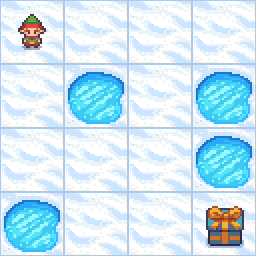

In [4]:
env_name = 'FrozenLake-v1'
env = gym.make(env_name, render_mode="rgb_array")
# getting action space
print(f"action space: {env.action_space}")
s0, a0 = env.reset()
print(f"initial state: {s0}")
env.render()

### Section 1: Simple REINFORCE+Value Network

In [9]:
class Policy(nn.Module):
  def __init__(self, state_space, action_space):
    super().__init__()
    self.embed = nn.Embedding(state_space, 128)
    self.l1 = nn.Linear(128, 32)
    self.l2 = nn.Linear(32, action_space)

  def forward(self, state):
    x = self.embed(state)
    x = self.l1(x)
    x = F.relu(x)
    x = self.l2(x)
    return F.softmax(x, dim=-1)

class Value(nn.Module):
  def __init__(self, state_space):
    super().__init__()
    self.embed = nn.Embedding(state_space, 128)
    self.l1 = nn.Linear(128, 32)
    self.l2 = nn.Linear(32, 1)

  def forward(self, state):
    x = self.embed(state)
    x = self.l1(x)
    x = F.relu(x)
    x = self.l2(x)
    return x

pi = Policy(env.observation_space.n, env.action_space.n)
V = Value(env.observation_space.n)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pi = pi.to(device)
V = V.to(device)
pi_optim = torch.optim.AdamW(pi.parameters(), lr=0.001)
v_optim = torch.optim.AdamW(V.parameters(), lr=0.001)

In [14]:
for ep in range(2000):
  """
  Play
  """
  done = False
  st, _ = env.reset()
  ep_states = []
  ep_actions = []
  ep_rewards = []
  while not done:
    st = torch.tensor(st, dtype=torch.long, device=device)
    st = st.unsqueeze(dim=0)
    with torch.no_grad():
      probs = pi(st)

    at = torch.distributions.Categorical(probs).sample()
    next_state, rt, terminated, truncated, _ = env.step(at.item())
    done = terminated or truncated
    ep_rewards.append(rt)
    ep_states.append(st)
    ep_actions.append(at)
    st = next_state


  """
  Return
  """
  gamma = 0.99
  ret = 0
  Gt = []
  for rt in reversed(ep_rewards):
    ret = rt + gamma * ret
    Gt.insert(0, ret)
  Gt = torch.tensor(Gt, dtype=torch.float32, device=device)

  """
  Critic
  """
  states = torch.tensor(ep_states, dtype=torch.long, device=device)
  values = V(states)

  v_optim.zero_grad()
  v_loss = F.mse_loss(values.squeeze().squeeze(), Gt, reduction='mean')
  v_loss.backward()
  v_optim.step()

  """
  Advantage and Policy loss
  """
  # Returns on FrozenLake are mostly 0 or 1, so variance is huge early on – learning stalls. Normalizing with variance
  # for better training stability
  A = (Gt - values).detach()
  # A = (A - A.mean()) / (A.std() + 1e-8)
  dists = torch.distributions.Categorical(pi(states))
  log_probs = dists.log_prob(torch.stack(ep_actions))
  loss = -(log_probs*A).mean()
  pi_optim.zero_grad()
  loss.backward()
  pi_optim.step()

  if ep % 50 == 0:
    # Gt is good signal because we don't want just to find the path but also shortest path
    print(f"Episode:{ep}\tPiLoss:{loss:.3f}\tVloss:{v_loss:.3f}\tReturn:{Gt[0]:.3f}")

Episode:0	PiLoss:-1.229	Vloss:0.868	Return:0.000
Episode:50	PiLoss:-0.034	Vloss:0.003	Return:0.000
Episode:100	PiLoss:-0.012	Vloss:0.000	Return:0.000
Episode:150	PiLoss:-0.008	Vloss:0.000	Return:0.000
Episode:200	PiLoss:-0.150	Vloss:0.005	Return:0.000
Episode:250	PiLoss:-0.060	Vloss:0.005	Return:0.000
Episode:300	PiLoss:-0.235	Vloss:0.043	Return:0.000
Episode:350	PiLoss:0.939	Vloss:0.443	Return:0.860
Episode:400	PiLoss:0.017	Vloss:0.000	Return:0.000
Episode:450	PiLoss:0.027	Vloss:0.000	Return:0.000
Episode:500	PiLoss:-0.170	Vloss:0.028	Return:0.000
Episode:550	PiLoss:-0.395	Vloss:0.023	Return:0.000
Episode:600	PiLoss:1.469	Vloss:0.602	Return:0.886
Episode:650	PiLoss:0.002	Vloss:0.000	Return:0.000
Episode:700	PiLoss:0.011	Vloss:0.000	Return:0.000
Episode:750	PiLoss:0.063	Vloss:0.003	Return:0.000
Episode:800	PiLoss:0.017	Vloss:0.000	Return:0.000
Episode:850	PiLoss:0.006	Vloss:0.000	Return:0.000
Episode:900	PiLoss:-0.178	Vloss:0.003	Return:0.000
Episode:950	PiLoss:-0.013	Vloss:0.000	Retur

### Section 2: PPO + GAE


In [39]:
class ActorCritic(nn.Module):
  def __init__(self, state_space, action_space):
    super().__init__()
    self.embed = nn.Embedding(state_space, 128)
    self.ln1 = nn.Linear(128, 64)
    self.ln2 = nn.Linear(64, 32)
    self.policy_head = nn.Linear(32, action_space)
    self.value_head = nn.Linear(32, 1)

  def forward(self, state):
    x = self.embed(state)
    x = self.ln1(x)
    x = F.relu(x)
    x = F.relu(self.ln2(x))
    policy_logits = self.policy_head(x)
    value_out = self.value_head(x)
    return policy_logits, value_out


a2c_model = ActorCritic(env.observation_space.n, env.action_space.n)

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
a2c_model = a2c_model.to(device)
optim = torch.optim.AdamW(a2c_model.parameters(), lr=0.001)

What does **GAE** do?

In actor-critic we need Advantage(t)
```
Aₜ = Qᶲ(sₜ, aₜ)-Vᶲ(sₜ)
```
The advantage says “how much better did this action at this state turn out than I normally expect from this state?"

#### Naive approach: Monte Carlo
A naive approach is to what we did in previous section, using Monte Carlo:
* calculate return using a discount factor
* diff to value prediction

```
Gₜ = ∑ₖ γᵏ r(t+k) , Aₜ=Gₜ - Vᶲ(sₜ)
```

#### Simple approach: 1-step TD
A simple approach is to use 1-step TD: Estimate return as current reward plus the value at steo t+1
```
Aₜ = rₜ + Vᶲ(s(t+1)) - Vᶲ(sₜ)
```

MC gives perfect long-term credit at the cost of huge variance; TD is calm but myopic. **Generalised Advantage Estimation (GAE) bridges the two.**
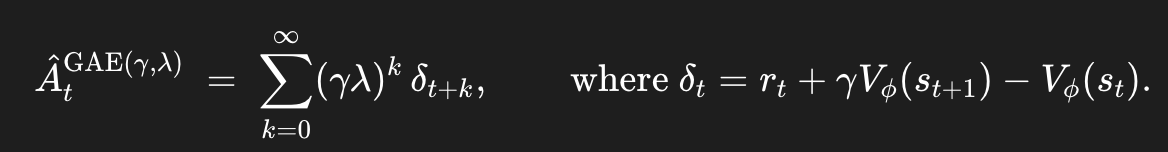


λ∈[0,1] is bias/variance knob
* λ=0 is 1-step TD
* λ=1 is pure MC
Mid-values trade off smoothly; practitioners often use 0.95.


In [41]:
def GAE(rewards: torch.Tensor,
        dones:   torch.Tensor,
        values:  torch.Tensor,
        gamma: float = 0.99,
        lam:   float = 0.95):
    """
    Generalised Advantage Estimation (Schulman et al., 2016).

    Args
    ----
    rewards : [T]   — r_t
    dones   : [T]   — 1.0 if episode ended at t, else 0.0
    values  : [T+1] — V(s_t) for t=0…T  *including* bootstrap value V(s_T)
    gamma   : discount factor
    lam     : GAE λ

    Returns
    -------
    advantages : [T]
    returns    : [T]   ( = advantages + values[:-1] )
    """
    T = rewards.size(0)
    advantages = torch.zeros_like(rewards)
    next_adv = 0.0

    for t in reversed(range(T)):
        mask   = 1.0 - dones[t]              # 0 if terminal, else 1
        delta  = rewards[t] + gamma * values[t+1] * mask - values[t]
        next_adv = delta + gamma * lam * mask * next_adv
        advantages[t] = next_adv

    returns = advantages + values[:-1]       # V(s_t) + A_t
    return advantages, returns


In [42]:
def evaluate(model, n_episodes=10):
  """Evaluate the current policy"""
  total_rewards = []

  for _ in range(n_episodes):
      state, _ = env.reset()
      total_reward = 0
      done = False

      while not done:
          state_tensor = torch.tensor(state, dtype=torch.long, device=device)
          with torch.no_grad():
              logits, _ = model(state_tensor)
              action = torch.argmax(logits).cpu().item()

          state, reward, terminated, truncated, _ = env.step(action)
          total_reward += reward
          done = terminated or truncated

      total_rewards.append(total_reward)

  return np.mean(total_rewards)

In [44]:
TOTAL_STEPS     = 50*2048
N_STEPS         = 2048
CLIP_EPS        = 0.2
ENTROPY_COEF    = 0.01
VALUE_COEF      = 0.5
WINDOW          = 100
N_EPOCHS        = 4
BATCH_SIZE      = 64

all_steps = 0
update_count = 0
while all_steps < TOTAL_STEPS:
  states = []
  rewards = []
  values = []
  actions = []
  log_probs = []
  dones = []

  st, _ = env.reset()
  """
  Play
  """
  for t in range(N_STEPS):
    ### Roll-out (no grads)
    with torch.no_grad():
      st_tensor = torch.tensor(st, dtype=torch.long, device=device)
      logitst, vt = a2c_model(st_tensor)
      dist = torch.distributions.Categorical(logits=logitst)
      at = dist.sample()
      log_probt = dist.log_prob(at)

    next_state, rt, terminated, truncated, _ = env.step(at.detach().cpu().item())
    done = terminated or truncated

    values.append(vt.cpu().item())
    states.append(st)
    rewards.append(rt)
    log_probs.append(log_probt.cpu().item())
    actions.append(at)
    dones.append(done)

    # set the new state
    if done:
      st = env.reset()[0]
    else:
      st = next_state

  # Get final value for bootstrap (if not terminal)
  if not done:
    with torch.no_grad():
      s_last = torch.tensor(st, dtype=torch.long, device=device)
      _, next_value = a2c_model(s_last)
      values.append(next_value)
  else:
    values.append(0.0)

  values = torch.tensor(values, dtype=torch.float32, device=device)
  rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
  dones = torch.tensor(dones, dtype=torch.float32, device=device)
  log_probs = torch.tensor(log_probs, dtype=torch.float32, device=device)
  states = torch.tensor(states, dtype=torch.long, device=device)
  actions = torch.tensor(actions, dtype=torch.long, device=device)

  successes = sum(rewards)


  """
  estimate returns and advantages
  """
  advantages, returns = GAE(rewards, dones, values)
  advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
  returns = returns.to(device)
  advantages = advantages.to(device)

  """
  Optimization for policy and value model
  1. build dataset
  2. build dataloader
  3. in PPO multiple epochs
  4. loss
  5. optimize
  """
  dataset = torch.utils.data.TensorDataset(states, actions, log_probs,
                                             returns, advantages)

  loader = torch.utils.data.DataLoader(dataset,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       drop_last=True)

  total_policy_loss = 0
  total_value_loss = 0
  total_entropy_loss = 0
  for epoch in range(N_EPOCHS):
  # loss has two parts
  # 1. Policy loss
  # 2. Value Model loss
  # 3. entropy (of p(a_t|s_t)) => for exploration, actions must be selected almost randomly at the begining
  # Since the Policy and Value models have same backbone with different heads
  # we combine the loss
    for s_b, a_b, logp_b, ret_b, adv_b in loader:
      logits, values = a2c_model(s_b)
      dist = torch.distributions.Categorical(logits=logits)
      new_logprobs = dist.log_prob(a_b)
      entropy  = dist.entropy().mean()

      ratio = torch.exp(new_logprobs - logp_b)
      surr1 = ratio * adv_b
      surr2 = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * adv_b

      policy_loss = -torch.min(surr1, surr2).mean()
      value_loss  = F.mse_loss(values.squeeze(), ret_b)

      ret_b = ret_b.detach()
      adv_b = adv_b.detach()

      loss = policy_loss + VALUE_COEF * value_loss - ENTROPY_COEF * entropy

      optim.zero_grad()
      loss.backward()
      optim.step()

      total_policy_loss += policy_loss.item()
      total_value_loss += value_loss.item()
      total_entropy_loss += entropy.item()

    all_steps += N_STEPS

    if update_count % 10 == 0:
        total_reward = evaluate(a2c_model)
        print(f"Steps:{all_steps:6d}  Loss:{loss:.3f}  "
              f"E[rewards]: {total_reward:.3f}  "
              f"sum(rewards) {sum(rewards)}")

Steps:  2048  Loss:0.006  E[rewards]: 0.600  sum(rewards) 20.0
Steps:  4096  Loss:0.082  E[rewards]: 0.500  sum(rewards) 20.0
Steps:  6144  Loss:0.228  E[rewards]: 0.500  sum(rewards) 20.0
Steps:  8192  Loss:-0.000  E[rewards]: 0.600  sum(rewards) 20.0
Steps: 10240  Loss:0.022  E[rewards]: 0.600  sum(rewards) 28.0
Steps: 12288  Loss:-0.193  E[rewards]: 0.900  sum(rewards) 28.0
Steps: 14336  Loss:0.200  E[rewards]: 0.600  sum(rewards) 28.0
Steps: 16384  Loss:-0.080  E[rewards]: 0.400  sum(rewards) 28.0
Steps: 18432  Loss:0.076  E[rewards]: 0.500  sum(rewards) 24.0
Steps: 20480  Loss:0.109  E[rewards]: 0.400  sum(rewards) 24.0
Steps: 22528  Loss:0.120  E[rewards]: 0.700  sum(rewards) 24.0
Steps: 24576  Loss:-0.024  E[rewards]: 0.600  sum(rewards) 24.0
Steps: 26624  Loss:0.129  E[rewards]: 0.400  sum(rewards) 16.0
Steps: 28672  Loss:0.044  E[rewards]: 0.700  sum(rewards) 16.0
Steps: 30720  Loss:-0.041  E[rewards]: 0.500  sum(rewards) 16.0
Steps: 32768  Loss:-0.008  E[rewards]: 0.500  sum(